In [93]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.

DATA_PATH = 'data'


In [ ]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import cv2
from cer import calculate_cer

In [106]:
def load_characters(data_path):
    files = os.listdir(data_path)
    return [char if char != 'times' else '*' for char in files]

characters = load_characters(DATA_PATH)
print(characters)

['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']


In [107]:
def generate_strings(num_strings, chars, min_length, max_length):
    return [''.join(random.choices(chars, k=random.randint(min_length, max_length))) for _ in range(num_strings)]

random_strings = generate_strings(7, characters, 7, 14)
print(random_strings)

[',t4014-)02(w7', '-t2,8y(0', '--6y5yw', '9+4yh)(-9(7w7', 'y2928*w', '3yXX9*(', '*9((0)X94t-h']


In [108]:
def load_character_images(character):
    folder_name = 'times' if character == '*' else character
    paths = [os.path.join(f'{DATA_PATH}/{folder_name}', name) for name in os.listdir(f'{DATA_PATH}/{folder_name}') if os.path.isfile(os.path.join(f'{DATA_PATH}/{folder_name}', name))]
    
    images = []
    for path in paths:
        with Image.open(path) as img:
            images.append(img.convert('RGB'))
    
    return images

In [109]:
images_dict = {char: load_character_images(char) for char in characters}

In [110]:
def map_images_to_strings(strings, images):
    mapped_images = {}
    for string in strings:
        mapped_images[string] = [random.choice(images[char]) for char in string]
    return mapped_images

strings_to_images = map_images_to_strings(random_strings, images_dict)

In [111]:
def extract_data(images):
    X, y = [], []
    for char, imgs in images.items():
        for img in imgs:
            X.append(np.array(img).flatten())
            y.append(char)
    return X, y

In [112]:
X_data, y_data = extract_data(images_dict)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [115]:
for string in strings_to_images:
    vectorized_images = [np.array(img).flatten() for img in strings_to_images[string]]
    predictions = knn_classifier.predict(vectorized_images)
    
    accuracy = accuracy_score(predictions, list(string))
    print(string, predictions, accuracy)

,t4014-)02(w7 [',' 't' '4' '0' '1' '4' '-' ')' '0' '2' '(' 'w' '7'] 1.0
-t2,8y(0 ['-' 't' '2' ',' '8' 'y' '(' '0'] 1.0
--6y5yw ['-' '-' '6' 'y' '5' 'y' 'w'] 1.0
9+4yh)(-9(7w7 [',' '+' '4' 'y' 'h' ')' '(' '-' '-' '(' '7' 'w' '7'] 0.8461538461538461
y2928*w ['y' ')' '9' '2' '8' '*' 'w'] 0.8571428571428571
3yXX9*( ['3' 'y' 'X' 'X' '9' '*' '('] 1.0
*9((0)X94t-h ['*' '9' '(' '(' '0' ')' 'X' '9' '4' 't' '-' 'h'] 1.0


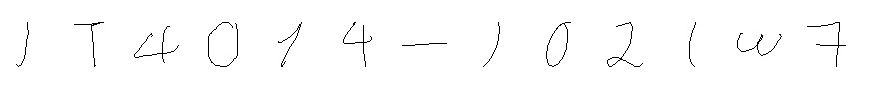

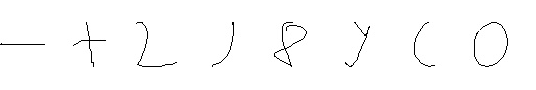

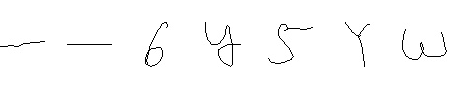

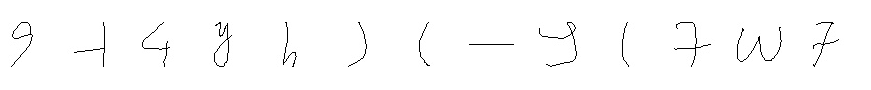

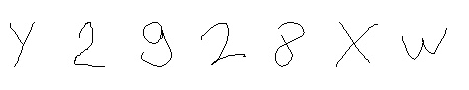

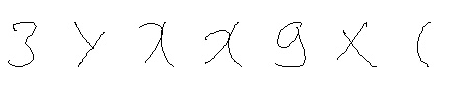

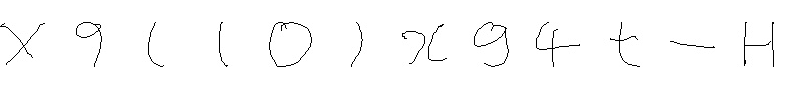

In [ ]:
def create_combined_image(images):
    space_between = 22  # Пробел между символами
    total_width = len(images) * (45 + space_between)
    
    combined_image = Image.new('RGB', (total_width, 90), (255, 255, 255))
    
    for i, img in enumerate(images):
        combined_image.paste(img, (i * (45 + space_between), 22))
    
    return combined_image

combined_images = []
correct_strings = []

for string in strings_to_images:
    combined_img = create_combined_image(strings_to_images[string])
    
    combined_images.append(combined_img)
    correct_strings.append(string)
    
    display(combined_img)

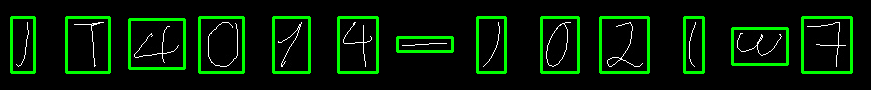

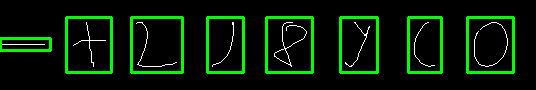

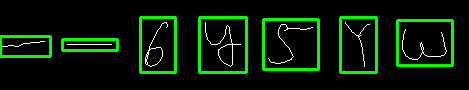

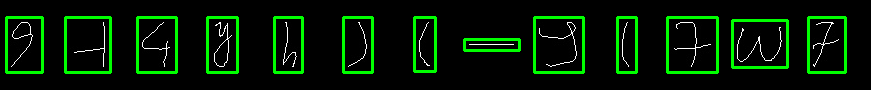

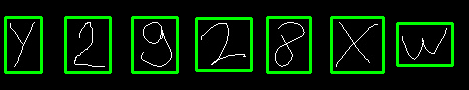

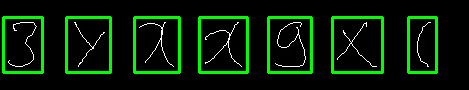

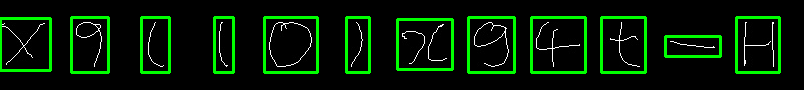

In [121]:
results = []

def gen_45x45_image_from(image):
    w, h = image.size

    nimg = Image.new('RGB', (45, 45), (255, 255, 255))
    nimg.paste(image, ((45 - w) // 2, (45 - h) // 2))
    
    return nimg

for image in combined_images:
    image_array = np.array(image)
    
    # Инвертируем цвета изображения
    image_array = 255 - image_array
    
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 12)
    
    dilated_image = cv2.dilate(blurred_image, None, iterations=2)
    
    contours = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    
    sorted_boxes = sorted(bounding_boxes, key=lambda b: b[0])
    
    orig_copy = image_array.copy()
    
    rois = []
    
    for (x, y, w, h) in sorted_boxes:
        if w * h < 160:  # Игнорировать слишком маленькие области
            continue
        
        roi_image = image_array[y:y+h, x:x+w]
        
        # Рисуем прямоугольник вокруг найденной области
        cv2.rectangle(orig_copy, (x,y), (x+w,y+h), (0,255,0), 2)
        
        rois.append(np.array(gen_45x45_image_from(Image.fromarray(255 - roi_image))).flatten())

    display(Image.fromarray(orig_copy))

    results.append(knn_classifier.predict(rois))

In [122]:
for i, r in enumerate(results):
    print(correct_strings[i], r, accuracy_score(r, list(correct_strings[i])))

,t4014-)02(w7 [',' '1' '1' ',' ',' '4' '-' ')' '(' ',' '(' '1' '7'] 0.46153846153846156
-t2,8y(0 ['-' '1' '2' ',' '(' ',' '(' '0'] 0.625
--6y5yw ['-' '-' '(' '1' '5' ',' '('] 0.42857142857142855
9+4yh)(-9(7w7 [',' '1' '4' ')' '1' ')' '(' '-' '-' '(' '7' 'w' '7'] 0.6153846153846154
y2928*w [',' ')' '2' '2' '8' '*' 'w'] 0.5714285714285714
3yXX9*( ['3' ',' 'X' 'X' '2' '*' '('] 0.7142857142857143
*9((0)X94t-h [',' '9' '(' '(' '0' ')' 'X' '9' '4' '(' '-' '-'] 0.75


In [124]:
def modify_string(string):
    characters_list = list(string)
    
    indices_to_modify = random.sample(range(len(string)), random.randint(0, len(string)))
    
    for index in indices_to_modify:
        characters_list[index] = random.choice(characters)
        
    return ''.join(characters_list)


In [125]:
for result in results:
    original_string = ''.join(result)
    
    modified_string = modify_string(original_string)
    
    cer_value = calculate_cer(list(original_string), list(modified_string))
    
    print(f'Original: {original_string}, Modified: {modified_string}, CER: {cer_value}')

Original: ,11,,4-)(,(17, Modified: )w(,,74)()+h7, CER: 0.32
Original: -12,(,(0, Modified: -2Xw(,w0, CER: 0.26666666666666666
Original: --(15,(, Modified: --(15,y, CER: 0.07692307692307693
Original: ,14)1)(--(7w7, Modified: 3Xt91078+66h2, CER: 0.52
Original: ,)228*w, Modified: ,)2-8Xw, CER: 0.15384615384615385
Original: 3,XX2*(, Modified: 3-322*), CER: 0.3076923076923077
Original: ,9((0)X94(--, Modified: w93(0XX94(--, CER: 0.13043478260869565
